To start, we import any needed packages, load our datasets as CSV files, and do any initial cleaning we need before combining the two datasets into one dataframe. We then define our features and split data into training and test sets for later model training. Our split is 80% training and 20% testing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Load datasets
# Need to upload the two CSV files into the left hand file upload pane if it is in google colab
islp = pd.read_csv("ISLP_credit_default_copy.csv")
ybi = pd.read_csv("ybi_Credit Default.csv")

# Preprocess column names (lowercase, strip spaces)
islp.columns = islp.columns.str.strip().str.lower()
ybi.columns = ybi.columns.str.strip().str.lower()

# Convert categorical fields in ISLP to binary (Yes/No to 1/0)
islp['default'] = islp['default'].apply(lambda x: 1 if str(x).strip().lower() == "yes" else 0)
islp['student'] = islp['student'].apply(lambda x: 1 if str(x).strip().lower() == "yes" else 0)

# Create 'student' column in ybi based on age (18-23 as student)
ybi['student'] = ybi['age'].apply(lambda age: 1 if 18 <= age <= 23 else 0)
# Convert default to binary
if 'default' in ybi.columns:
    ybi['default'] = ybi['default'].apply(lambda x: 1 if str(x).strip().lower() == "yes" or x == 1 else 0)

# Rename 'loan' to 'balance' in ybi to match ISLP schema
if 'loan' in ybi.columns:
    ybi.rename(columns={'loan': 'balance'}, inplace=True)

# Keep only the relevant columns: student, balance, income, default
islp_clean = islp[['student', 'balance', 'income', 'default']]
ybi_clean  = ybi[['student', 'balance', 'income', 'default']]

# Combine datasets
combined = pd.concat([islp_clean, ybi_clean], ignore_index=True)

# Define features and target
features = ['student', 'balance', 'income']
target = 'default'
X = combined[features]
y = combined[target]

# Split the data into training and test sets (stratify by target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


Here, we prepare our data for initial visualization, creating a correlation heatmap, balance distribution histogram, income distribution histogram, and a default countplot.

In [ ]:
def visualize_data(df):
    """Plot histograms for 'balance' and 'income', a countplot for 'default', and a correlation heatmap."""
    plt.figure(figsize=(12, 8))

    # Balance distribution histogram
    plt.subplot(2, 2, 1)
    sns.histplot(df['balance'], kde=False, color='skyblue', bins=30)
    plt.title('Balance Distribution')

    # Income distribution histogram
    plt.subplot(2, 2, 2)
    sns.histplot(df['income'], kde=False, color='lightgreen', bins=30)
    plt.title('Income Distribution')

    # Default countplot
    plt.subplot(2, 2, 3)
    sns.countplot(x='default', data=df, palette='pastel')
    plt.title('Count of Default')

    # Feature correlation heatmap
    plt.subplot(2, 2, 4)
    corr = df[['student', 'balance', 'income', 'default']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')

    plt.tight_layout()
    plt.show()


Now, we begin to train our logistic regression model, setting up our classification report, confusion matrix, and ROC curve.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay

def train_logistic_regression(X_train, X_test, y_train, y_test):
    """Train logistic regression with scaling and SMOTE; use GridSearchCV for hyperparameter tuning."""
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, solver='lbfgs'))
    ])
    rf_param_grid = {
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__class_weight': [None, 'balanced']
    }
    grid = GridSearchCV(pipeline, rf_param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    print("Best Logistic Regression parameters:", grid.best_params_)
    best_model = grid.best_estimator_

    # Predictions and evaluation
    y_pred = best_model.predict(X_test)
    print("\nLogistic Regression Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
    disp.plot(cmap='Blues')
    plt.title("Logistic Regression Confusion Matrix")
    plt.show()

    # Plot ROC curve
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.title("Logistic Regression ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.show()


Next, we train our Random Forest and set up our classification report, confusion matrix, and ROC curve.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, X_test, y_train, y_test):
    """Train random forest with SMOTE; use GridSearchCV for hyperparameter tuning."""
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42))
    ])
    param_grid = {
        # number of trees in the forest
        'clf__n_estimators':        [100, 200, 500],
        # maximum depth of each tree
        'clf__max_depth':           [None, 5, 10],
        # minimum number of samples required to split an internal node
        'clf__min_samples_split':   [2, 5],
        # minimum number of samples required to be at a leaf node
        'clf__min_samples_leaf':    [1, 2],
        # whether bootstrap samples are used when building trees
        'clf__bootstrap':           [True, False],
        # class‑weighting strategies for imbalanced data
        'clf__class_weight':        [None, 'balanced'],
        # a node will be split if this split induces a decrease of the impurity greater than this value
        'clf__min_impurity_decrease': [0.001, 0.01]
    }
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    print("Best Random Forest parameters:", grid.best_params_)
    best_model = grid.best_estimator_

    # Predictions and evaluation
    y_pred = best_model.predict(X_test)
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
    disp.plot(cmap='Greens')
    plt.title("Random Forest Confusion Matrix")
    plt.show()

    # Plot ROC curve
    if hasattr(best_model.named_steps['clf'], "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = best_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color='green')
    plt.plot([0,1], [0,1], 'k--')
    plt.title("Random Forest ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.show()


Finally, we set up our neural network and its classification report, confusion matrix, and ROC curve.

In [ ]:
from sklearn.neural_network import MLPClassifier

def train_neural_network(X_train, X_test, y_train, y_test):
    #Train MLP with scaling and SMOTE; use GridSearchCV for tuning; include a learning curve
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', MLPClassifier(max_iter=2000, random_state=42))
    ])
    mlp_param_grid = {
        # Architecture: number of neurons per hidden layer
        'clf__hidden_layer_sizes': [
            (50,), (100,), (100,50), (100,100), (200,100), (200,200)
        ],
        # Activation functions
        'clf__activation': ['relu', 'tanh'],
        # Solver algorithms
        'clf__solver': ['adam', 'sgd'],
        # L2 regularization strength
        'clf__alpha': [1e-3, 1e-2],
        # Initial learning rate for 'sgd' and 'adam'
        'clf__learning_rate_init': [1e-3, 1e-2],
    }
    grid = GridSearchCV(pipeline, mlp_param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    print("Best Neural Network parameters:", grid.best_params_)
    best_model = grid.best_estimator_

    # Predictions and evaluation
    y_pred = best_model.predict(X_test)
    print("\nNeural Network Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
    disp.plot(cmap='Purples')
    plt.title("Neural Network Confusion Matrix")
    plt.show()

    # Plot ROC curve
    if hasattr(best_model.named_steps['clf'], "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]
    else:
        y_prob = best_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})", color='purple')
    plt.plot([0,1], [0,1], 'k--')
    plt.title("Neural Network ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.show()

    # Plot learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='orange', label='Cross-validation score')
    plt.title("Learning Curve for MLP")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


Here, we visualize the distribution of key features and explore their relationship with our target variable, 'default'. We've used histograms, bar charts, and correlation heatmaps to uncover trends or patterns, in turn helping us understand how our data is distributed, feature relevance, and informs our model selection.

Visualizing Data:


<ipython-input-3-30be88b49e9e>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default', data=df, palette='pastel')


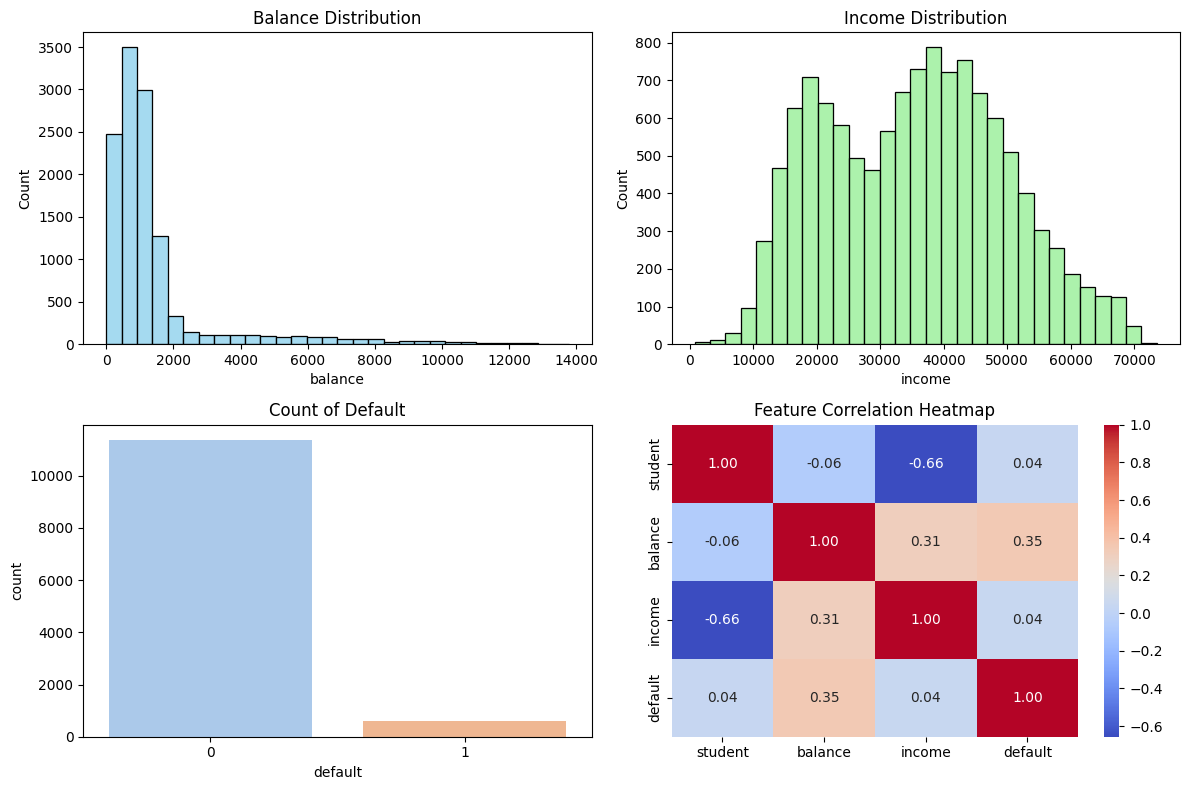

In [ ]:
# Visualize combined data distributions and relationships
print("Visualizing Data:")
visualize_data(combined)

Now, we train our logistic regression, random forest, and neural networks and generate visualizations to understand how well they are working.

Training Logistic Regression:
Best Logistic Regression parameters: {'clf__C': 0.01, 'clf__class_weight': None}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.88      0.92      2277
           1       0.21      0.62      0.31       123

    accuracy                           0.86      2400
   macro avg       0.59      0.75      0.62      2400
weighted avg       0.94      0.86      0.89      2400



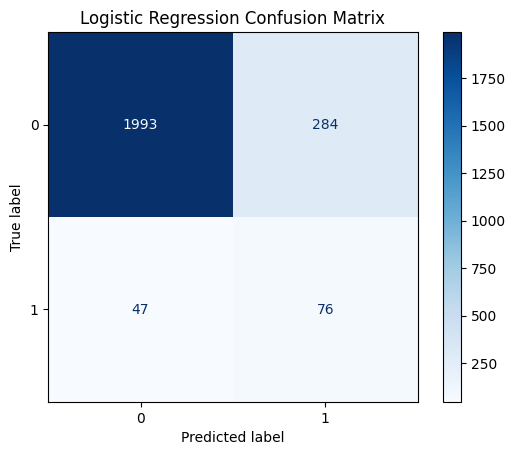

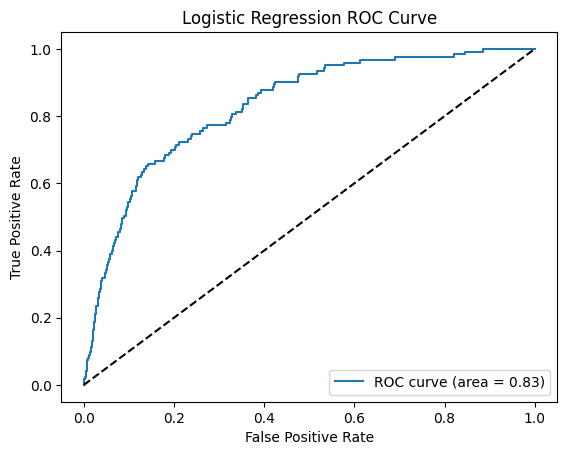

In [ ]:
# Train and evaluate models
print("Training Logistic Regression:")
train_logistic_regression(X_train, X_test, y_train, y_test)

Training Random Forest:
Best Random Forest parameters: {'clf__bootstrap': False, 'clf__class_weight': None, 'clf__max_depth': None, 'clf__min_impurity_decrease': 0.001, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      2277
           1       0.19      0.89      0.32       123

    accuracy                           0.80      2400
   macro avg       0.59      0.84      0.60      2400
weighted avg       0.95      0.80      0.86      2400



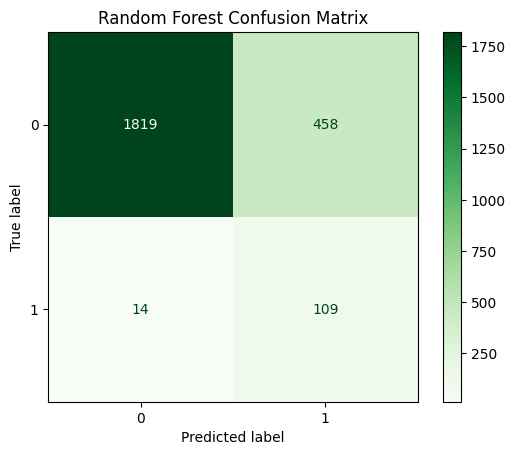

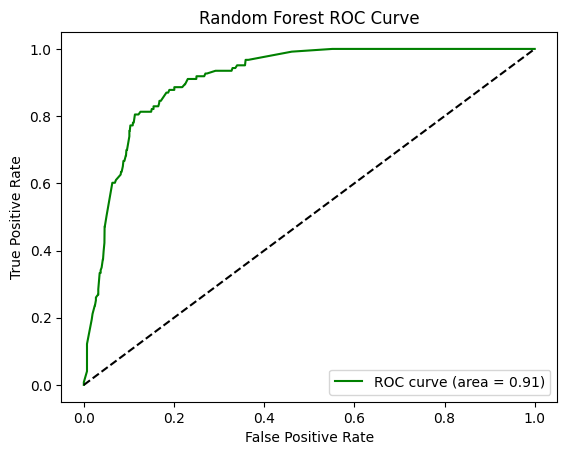

In [ ]:
# Train random forest
print("Training Random Forest:")
train_random_forest(X_train, X_test, y_train, y_test)

Training Neural Network:
Best Neural Network parameters: {'clf__activation': 'tanh', 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (200, 200), 'clf__learning_rate_init': 0.001, 'clf__solver': 'adam'}

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2277
           1       0.25      0.88      0.39       123

    accuracy                           0.86      2400
   macro avg       0.62      0.87      0.66      2400
weighted avg       0.95      0.86      0.89      2400



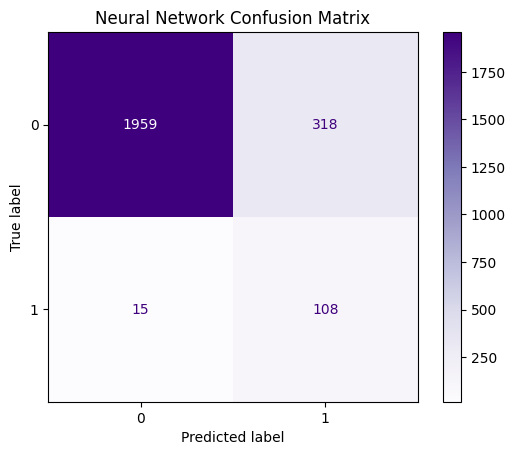

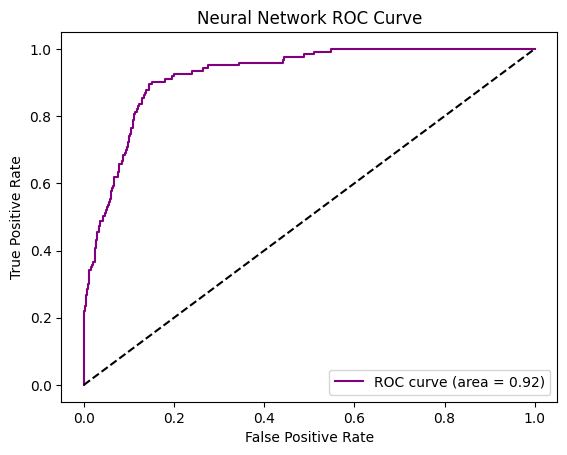

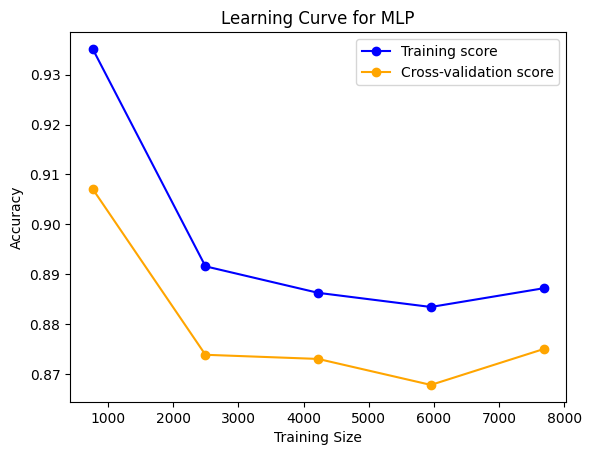

In [ ]:
# Train neural network
print("Training Neural Network:")
train_neural_network(X_train, X_test, y_train, y_test)

Now that we have run our models and analyzed the accuracy of each model, we can draw our conclusions about efficacy and accuracy in identifying defaulters on credit card payments.

Based on our analysis, we hold firm on our thought that the random forest and neural network are the most accurate and effective and therefore the best models to utilize in order to predict credit card default. In terms of our predictors, balance was identified as the best predictor of credit card default, i.e. the total amount of money that the cardholder owes to the credit card company.